In [1]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()
base_dir = os.getenv('BASE_DIR')

In [2]:
folder_name = "landmarks_angle"

data = np.concatenate([
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/15,15/seq_npy_1723053950.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/15,15/seq_npy_flip_1723053989.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/15,15/seq_npy_flip_shift_1723054057.npy')),
    np.load(os.path.join(base_dir, f'seq_data/{folder_name}/15,15/seq_npy_shift_1723054018.npy'))
], axis=0)

print(data.shape)
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(5112, 15, 235)


In [3]:
from setting import actions
from keras.utils import to_categorical

# 데이터 분리 및 전처리
x_data = data[:, :, :-1]    # 시퀀스의 마지막 요소 제외한 모든 값 가져와 할당
labels = data[:, 0, -1]     # 마지막 요소는 라벨 값

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))

print(x_data.shape)
print(labels.shape)
print(y_data.shape)         # y_data 형태 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...]
print(np.unique(labels))    # 레이블 값 출력


(5112, 15, 234)
(5112,)
(5112, 10)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [4]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# 데이터셋 분할 ( train data : validation data = 7 : 3 )
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=2020)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3578, 15, 234) (3578, 10)
(1534, 15, 234) (1534, 10)


In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 모델 정의
model = Sequential([
    LSTM(128, activation='relu', input_shape=x_train.shape[1:3]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax'),
])

# 모델 컴파일 (최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# 모델 요약
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               185856    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 194762 (760.79 KB)
Trainable params: 194762 (760.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 모델 훈련
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=False, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20, verbose=1, mode='auto'),
        # early stopping 적용
        # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ]
)

Epoch 1/100


56/56 [==============================] - ETA: 0s - loss: 1.7366 - acc: 0.3675
Epoch 1: saving model to models\model.h5
56/56 [==============================] - 3s 24ms/step - loss: 1.7366 - acc: 0.3675 - val_loss: 1.3534 - val_acc: 0.4980 - lr: 0.0010
Epoch 2/100
10/56 [====>.........................] - ETA: 0s - loss: 1.2659 - acc: 0.5406

c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/56 [===========================>..] - ETA: 0s - loss: 1.1115 - acc: 0.6039
Epoch 2: saving model to models\model.h5
56/56 [==============================] - 1s 17ms/step - loss: 1.1085 - acc: 0.6045 - val_loss: 0.7851 - val_acc: 0.7288 - lr: 0.0010
Epoch 3/100
54/56 [===========================>..] - ETA: 0s - loss: 0.8245 - acc: 0.7031
Epoch 3: saving model to models\model.h5
56/56 [==============================] - 1s 17ms/step - loss: 0.8192 - acc: 0.7043 - val_loss: 0.7210 - val_acc: 0.7438 - lr: 0.0010
Epoch 4/100
53/56 [===========================>..] - ETA: 0s - loss: 0.6281 - acc: 0.7759
Epoch 4: saving model to models\model.h5
56/56 [==============================] - 1s 21ms/step - loss: 0.6269 - acc: 0.7756 - val_loss: 0.6914 - val_acc: 0.7555 - lr: 0.0010
Epoch 5/100
55/56 [============================>.] - ETA: 0s - loss: 0.6128 - acc: 0.7832
Epoch 5: saving model to models\model.h5
56/56 [==============================] - 1s 20ms/step - loss: 0.6131 - acc: 0.7828 - val_

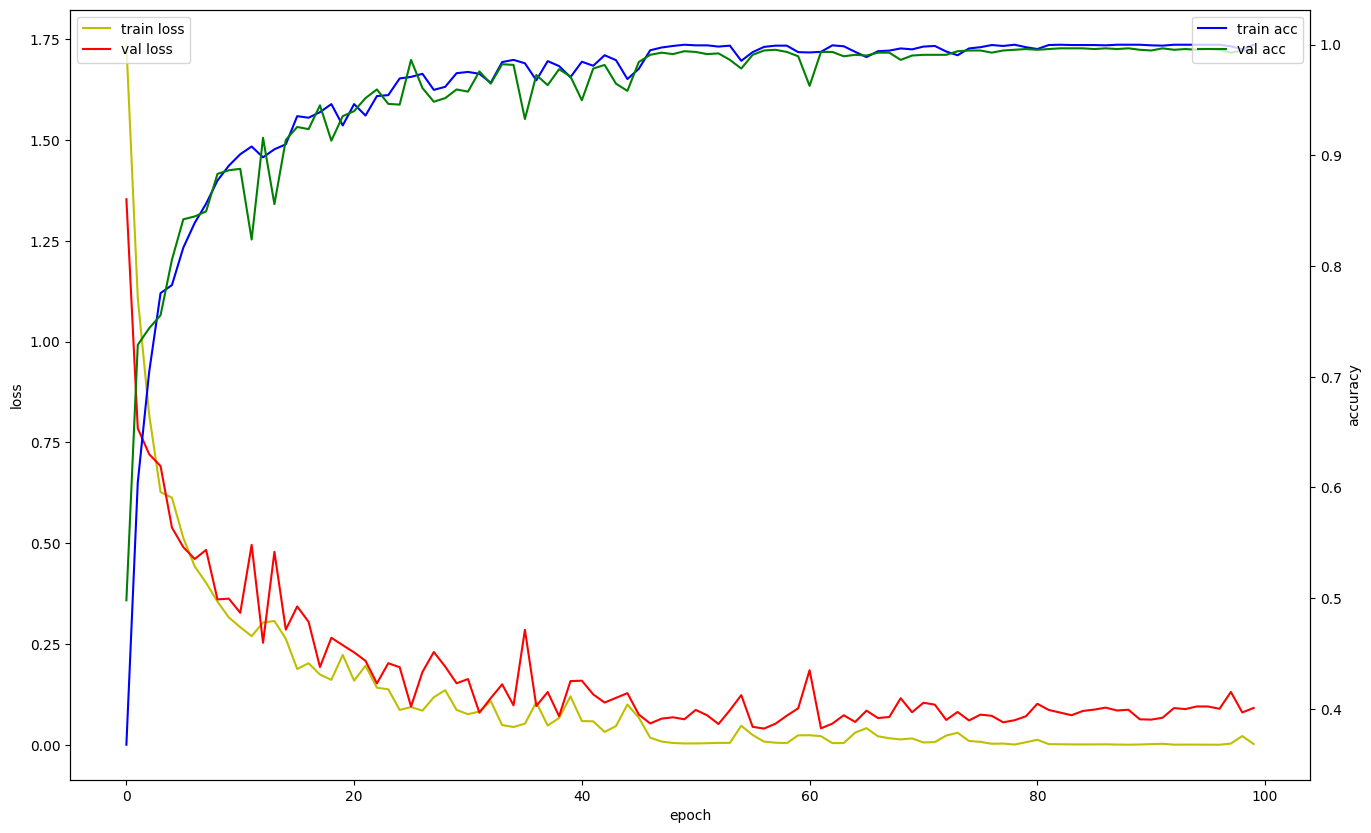

In [7]:
import matplotlib.pyplot as plt

# 학습 데이터/검증 데이터 정확도/손실 그래프
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()